In [2]:
import pandas as pd
def get_zz_quote(code,end_date=None,count=None,start_date=None):
    '''获取中证指数行情,返回panel结构'''
    from jqdata import get_trade_days,jy
    if isinstance(code,str):
        code=[code]
    code.sort()
    code = [x[:6] for x in code]
    days = get_trade_days(start_date,end_date,count)
    code_df = jy.run_query(query(
         jy.SecuMain.InnerCode,jy.SecuMain.SecuCode,jy.SecuMain.ChiName
        ).filter(
        jy.SecuMain.SecuCode.in_(code)).order_by(jy.SecuMain.SecuCode))
    df = jy.run_query(query(
             jy.LC_IndexDerivative).filter(
            jy.LC_IndexDerivative.IndexCode.in_(code_df.InnerCode),
            jy.LC_IndexDerivative.TradingDay.in_(days),
            ))
    df2  = pd.merge(code_df, df, left_on='InnerCode',right_on='IndexCode').set_index(['TradingDay','SecuCode'])
#     df2.drop(['InnerCode','IndexCode','ID','UpdateTime','JSID','OpenInterest','SettleValue','IndexCSIType'],axis=1,inplace=True)
    return df2.to_panel()


def get_bull_or_bear(series,order=100):
    '''获取时间区间所处的牛熊市状态
    传入: series如close, order代表划分前后追朔的数据量,数据量越大,精度越小
    返回: 交易日的牛熊市的分类，series'''
    from scipy.signal import  argrelextrema
    # 利用scipy在前后order个交易日内寻找极值点
    x=series.values
    high = argrelextrema(x,np.greater,order=order)[0]
    low = argrelextrema(x,np.less,order=order)[0]

    high_s = pd.Series('high',series.iloc[high].index)
    low_s = pd.Series('low',series.iloc[low].index)

    data1 = pd.concat([high_s,low_s]).sort_index()
    other = []
    for i in range(len(data1)-1):               #去除重复值划分
        if data1.iloc[i]==data1.iloc[i+1]:
            other.append(data1.index[i])
    data1.drop(other,inplace=True)

    data1[series.index[-1]] = data1.iloc[-2]     #加上开头与结束的归类
    data1[series.index[0]] = data1.iloc[1]
    data1.sort_index(inplace=True)              # 获得牛熊分界点

    bull_data = pd.Series(False,series.index,name='is_bull')  #获得每一交易日属于牛市期还是熊市期
    if data1[0]=='high': is_bull =False 
    else:is_bull=True
    for i in range(len(data1)-1):
        if is_bull:
            bull_data[data1.index[i]:data1.index[i+1]] = True
            is_bull=False
        else:
            is_bull=True
    return bull_data

panel = get_zz_quote('000905.XSHG',end_date='2020-03-19',start_date='2007-01-15')
dv_datas = panel[:,:,'000905']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



In [4]:
dv_datas.tail()

,InnerCode,ChiName,ID,IndexCode,TotalMV,PE_TTM,PE_LYR,PB_LF,DividendRatio,InsertTime,UpdateTime,JSID,PCF_LYR,PCF_TTM,PS_LYR,PS_TTM
TradingDay,,,,,,,,,,,,,,,,
2020-03-12,4978,中证小盘500指数,637352638323,4978,9.024002e+12,26.8357,24.4410,1.9014,1.2879,2020-03-12 18:23:53,2020-03-13 06:22:08,637396512564,21.0774,14.3915,1.2387,1.1668
2020-03-13,4978,中证小盘500指数,637439124045,4978,8.948629e+12,26.3868,24.0370,1.8851,1.2986,2020-03-13 18:22:59,2020-03-13 18:22:59,637439124046,20.7419,14.2466,1.2280,1.1560
2020-03-16,4978,中证小盘500指数,637698220993,4978,8.543340e+12,25.1757,22.9331,1.7996,1.3604,2020-03-16 18:23:40,2020-03-16 18:23:40,637698220994,19.7278,13.5964,1.1724,1.1038
2020-03-17,4978,中证小盘500指数,637784643617,4978,8.556130e+12,25.2111,22.9503,1.8022,1.3583,2020-03-17 18:22:47,2020-03-18 06:21:48,637827708186,19.7475,13.6105,1.1737,1.1054
2020-03-18,4978,中证小盘500指数,637871205060,4978,8.408909e+12,24.7604,22.5540,1.7712,1.3821,2020-03-18 18:26:44,2020-03-18 18:26:44,637871205061,19.3498,13.3564,1.1532,1.0864


# 未来6个月收益展示为bar
### 绿色为极值点

未来6个月收益展示为bar
绿色为极值点


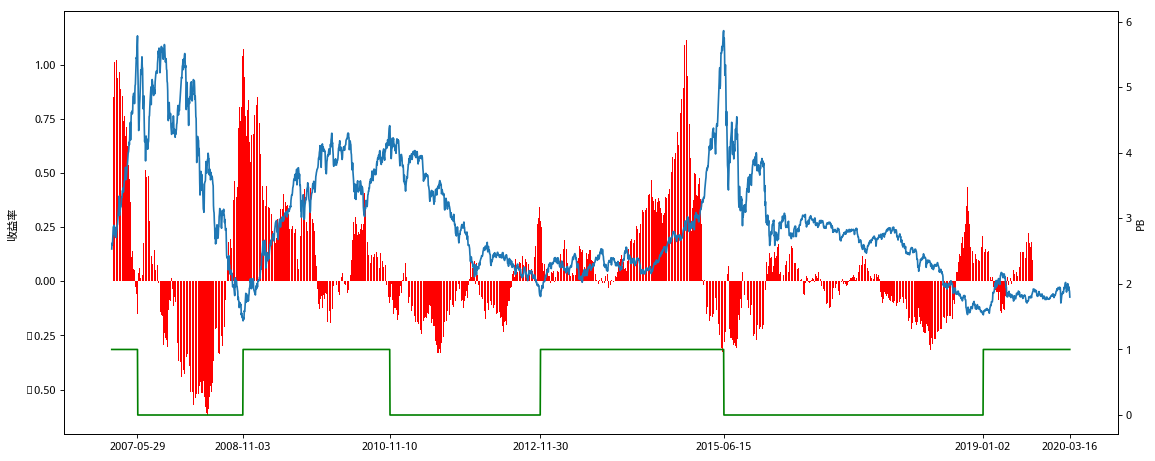

In [3]:
forward_date = 122 
returns  = get_price("000905.XSHG",end_date='2020-03-16',start_date='2007-01-15',fields='close'
                    ).close.pct_change(forward_date).shift(-forward_date)


df = get_bull_or_bear(dv_datas.PB_LF,243)  #寻找极值点
year =  df[(df*1).diff(-1)!=0].index.date
l  =dv_datas.index.date.tolist()
where = [l.index(x) for x in year]


fig, ax1 = plt.subplots(figsize=(17, 7),dpi=80)
ax1.bar(height=returns.values,x=range(0,len(returns)),color='red')
ax1.set_ylabel("收益率")

ax2 = ax1.twinx()  
ax2.plot(range(0,len(returns)),dv_datas.PB_LF.values,)
ax2.plot(range(0,len(returns)),(df.values*1),color='g',)
ax2.set_ylabel("PB")


plt.xticks(where,year) 
print ('''未来6个月收益展示为bar
绿色为极值点''')
plt.show()


# 收益展示为线条(6个月,一年, 两年)

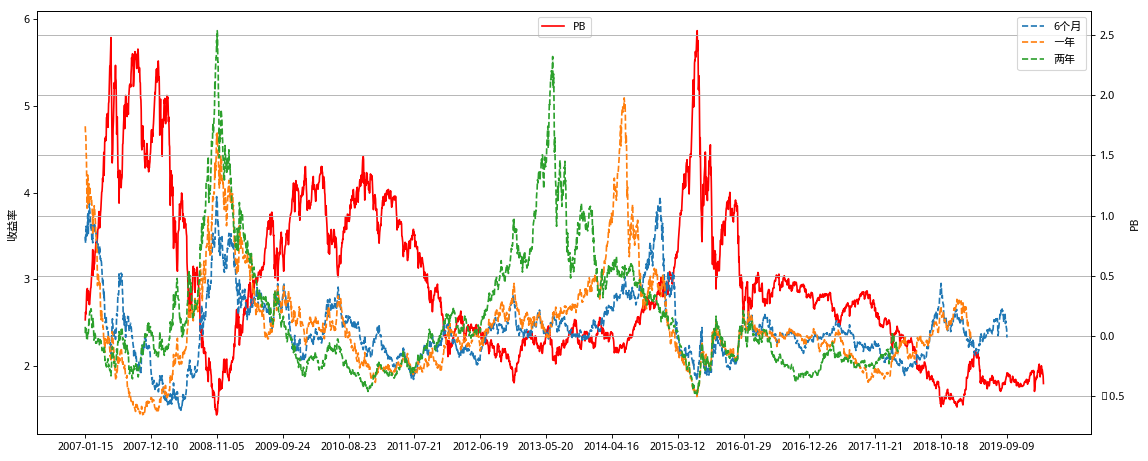

In [524]:
close  = get_price("000905.XSHG",end_date='2020-03-16',start_date='2007-01-15',fields='close'
                    ).close

return1 = close.pct_change(122).shift(-122)
return2 = close.pct_change(243).shift(-243)
return3 = close.pct_change(486).shift(-486)

fig, ax1 = plt.subplots(figsize=(17, 7),dpi=80)
ax1.plot(dv_datas.PB_LF.values,color='red')
ax1.set_ylabel("收益率")
plt.legend(['PB'],loc='upper center')
ax2 = ax1.twinx()  
ax2.plot(return1.values,linestyle="--",label='6个月')
ax2.plot(return2.values,linestyle="--",label='一年')
ax2.plot(return3.values,linestyle="--",label='两年')
ax2.set_ylabel("PB")

plt.xticks(range(0,len(return1),220),return1.index[::220].date,rotation=45)
plt.grid()
plt.legend()
plt.show()

In [492]:
all_data = pd.DataFrame([dv_datas.PB_LF,return1,return2,return3],
                        index = ['PB','未来6月收益','未来1年收益','未来两年收益']).T


all_data['极值点标识'] = df[(df*1).diff()!=0]*1
# all_data['极值点标识'] = ['']

In [493]:
df = get_bull_or_bear(dv_datas.PB_LF,243)  #寻找极值点
df[(df*1).diff()!=0]

TradingDay
2007-01-15     True
2007-05-30    False
2008-11-04     True
2010-11-11    False
2012-12-03     True
2015-06-16    False
2019-01-03     True
Name: is_bull, dtype: bool

In [501]:
all_data.to_csv('PB及收益.csv',encoding='utf_8_sig')